# Analysis of empirical CDF for covariance data calibration 

# Checklist

1. [ ] Generate better ground truth solutions for individual patch params
2. [x] Perform alignment and micropatch distribution
3. [x] Generate probability distribution for each patch using softmax
4. [x] For each patch - determine P_i
5. [x] Calculate P_GT from P_i
6. [x] Plot P_GT vs eCDF of P_GT

In [1]:
import numpy as np 
import cv2
import pickle
from matplotlib.patches import Ellipse
import pandas as pd
from scipy.stats import norm, multivariate_normal

from groundNAV_agent import *
from microp_distb import *
from distb_plotting_utils import *


# SAVE YOUR WORK
%load_ext autoreload
%autoreload 2
%autosave 180

/home/daniel-choate/miniconda3/envs/py39/lib/python3.9/site-packages/dash/dash.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, parse_version


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Autosaving every 180 seconds


In [2]:
# SfM files 
images_colm = '../TurfData/SfM_soln/images.txt'
cameras_colm = '../TurfData/SfM_soln/cameras.txt'
pts3d_colm = '../TurfData/SfM_soln/points3D_f.txt'

# Local images - folder
im_local = '../TurfData/local_imgs_10' # With 10 local images 
# im_local = '../TurfData/local_imgs_5' # With 5 local images

# Satellite reference image
sat_ref = '../TurfData/TurfSat.jpg'

In [3]:
# Create class 
gnav = gNAV_agent(images_colm, cameras_colm, pts3d_colm, im_local, sat_ref)

## 1. Implement pose estimations and ground truth solutions 

In [4]:
# Set ref frame - transform to ground-parallel coordinate frame
tform_ref_frame = gnav.set_ref_frame(gnav.pts_gnd_idx)
tform_ref_frame_pts = gnav.inv_homog_transform(tform_ref_frame)
print("Reference frame transformation \n", tform_ref_frame_pts)

Reference frame transformation 
 [[-1.55069060e-03  9.81197008e-01  1.93002661e-01 -1.21025836e-01]
 [-1.42845166e-01 -1.91240997e-01  9.71093270e-01  1.86102525e+00]
 [ 9.89743833e-01 -2.60636319e-02  1.40455805e-01  7.28134156e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


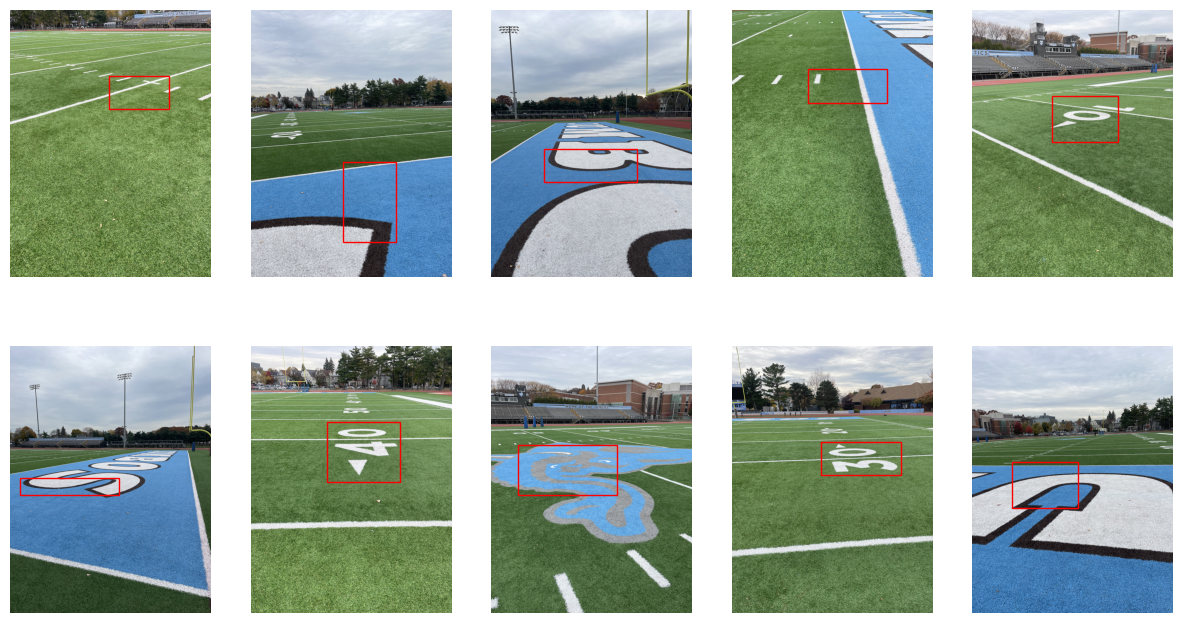

In [5]:
# Import mosaic parameters - arbitrarily obtained, can be modified
mosaic_params = np.load('../TurfData/GP_sections/mosaic_params.npy')
# Grab specified image points from local images 
gnav.grab_image_pts_tot(mosaic_params)

plt.figure(figsize=(15,8))
gnav.plot_gnd_pts()

In [6]:
# Generate projection of image sections 
for i in range(len(gnav.images_dict)):
    # STEP 1: Unit vectors in camera coords 
    pts_vec_c, pts_rgb_gnd = gnav.unit_vec_c(i)
    gnav.im_mosaic[i] = {'rgbc': pts_rgb_gnd}

    # STEP 2: Transformation matrix moves from camera coords to world coords
    id = gnav.im_ids[i]
    homog_w2c, homog_c2w = gnav.get_pose_id(id,i)
    # print('Homogeneous transformation from world to camera \n', homog_c2w)
    # print('\n Homogeneous transformation from camera to world \n', homog_w2c)

    # STEP 3: Transform to world coords
    origin_c, pts_loc_w, pts_vec_w = gnav.unit_vec_tform(pts_vec_c, gnav.origin_w, homog_c2w)
    # print('\n New camera frame origin = ', origin_c)
    
    # STEP 4: Get new points 
    ranges, new_pts_w = gnav.pt_range(pts_vec_w, homog_c2w, origin_c, i)
    # print('\nNew Points \n', new_pts_w)

    # STEP 5: Transfer points to reference frame
    __, new_pts_r, pts_vec_r = gnav.unit_vec_tform(new_pts_w, gnav.origin_w, tform_ref_frame_pts)

    # Convert points to grayscale 
    gray_c = gnav.conv_to_gray(gnav.im_mosaic[i]['rgbc'],i)
    # print(gray_c)

    # Put new points and grayscale colors in image mosaic
    gnav.im_mosaic[i]['pts'] = new_pts_r
    gnav.im_mosaic[i]['color_g'] = gray_c
    
    print("\nDone image ", i)


Done image  0

Done image  1

Done image  2

Done image  3

Done image  4

Done image  5

Done image  6

Done image  7

Done image  8

Done image  9


In [7]:
# IMPLEMENTING 'TRUTH SOLUTION' - once I find it in my files 

ind_params = np.load("../../s2/TerrainNav/ind_params.npy")
# print(ind_params)

gnav.ind_params_truth = ind_params
gnav.implement_guess_ind(gnav.ind_params_truth)

# IF NOT USING TRUTH - use converged solution (junk)
# # Initial guess parameters 
# # 5 image solution
# scale, yaw, x_g, y_g = 80, np.deg2rad(140), -52, 20
# # BEST after CONVERGENCE
# scale = 80.14819958
# yaw = 2.44777939
# x_g = -55.46495001
# y_g = 21.62910054

# tform_guess = gnav.tform_create(x_g,y_g,0,0,0,yaw)
# gnav.best_guess_tform = tform_guess
# gnav.best_guess_scale = scale

# # Implement
# gnav.implement_guess(gnav.best_guess_tform, gnav.best_guess_scale)

In [43]:
# Create visualization
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Image mosaic with reference map (initial guess)")

gnav.mosaic_w_ref_visualization(vis)

libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 88
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 88
pci id for fd 88: 8086:a7a0, driver iris
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using DRI3 for screen 0


## 2. Divide each patch into micropatches 

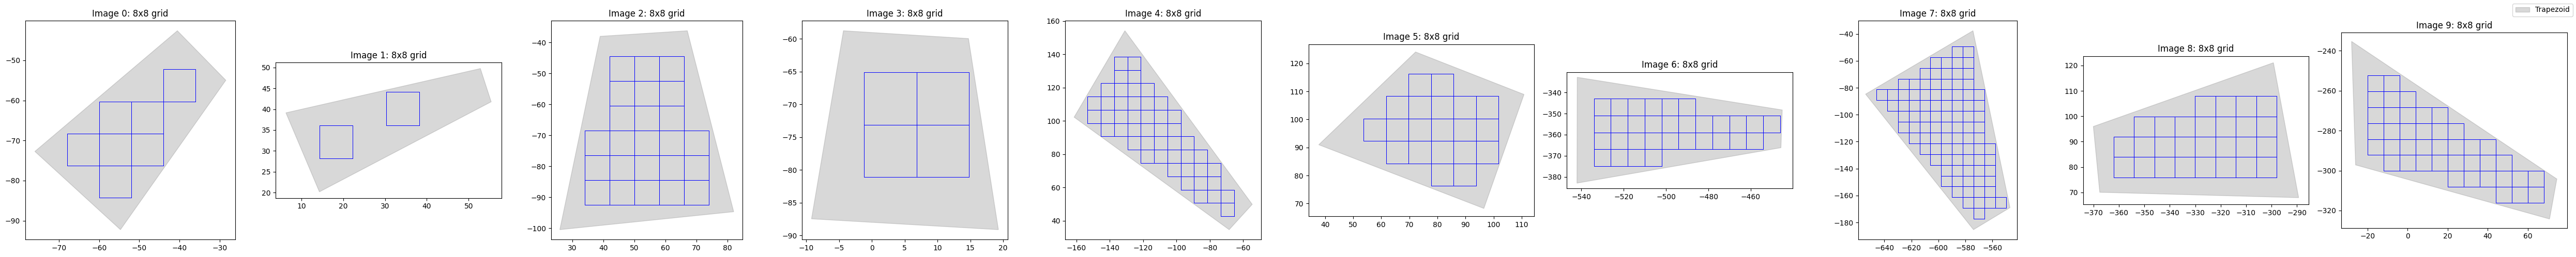

In [9]:
n = 8
micro_ps = gnav.micropatch_division(n)
gnav.micro_ps_local = copy.deepcopy(gnav.micro_ps) # KEEPING ORIGINAL, LOCAL IS WHAT WE EDIT
gnav.plot_traps_w_microps(n)

In [42]:
# VISUAL CHECK OF MICROPATCHES
# Check that the points are at least proper

# PLOTTING THE NEW SCENE MOSAIC

# Use open3d to create point cloud visualization 
# Create visualization 
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Mosaic scene with satellite reference")

# Create axes @ origin
axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10)
# vis.add_geometry(axis_origin)

# Add image patches
# for i in range(len(gnav.images_dict)):
# for i in range(2):
#     cloud = o3d.geometry.PointCloud()
#     cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[i]['pts'])
#     cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[i]['color_g'])
#     vis.add_geometry(cloud)


# Create point cloud for image points
for i in range(len(gnav.images_dict)):
    for j in range(len(micro_ps[i])):
        # print(j)
        cloud_micro = o3d.geometry.PointCloud()
        cloud_micro.points = o3d.utility.Vector3dVector(micro_ps[i][j]['pts'])
        # cloud_micro.paint_uniform_color([.75, 0.001*j, 0.002*j])
        cloud_micro.colors = o3d.utility.Vector3dVector(micro_ps[i][j]['color_g'])
        vis.add_geometry(cloud_micro)



# Create point cloud for reference cloud (satellite)
ref_cloud = o3d.geometry.PointCloud()
ref_cloud.points = o3d.utility.Vector3dVector(gnav.ref_pts)
ref_cloud.colors = o3d.utility.Vector3dVector(gnav.ref_rgb)
vis.add_geometry(ref_cloud)

# Run and destroy visualization 
vis.run()
vis.destroy_window()

libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 88
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 88
pci id for fd 88: 8086:a7a0, driver iris
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using DRI3 for screen 0


### SSD Process for micropatches 

In [11]:
ssds_curr_micro = [{} for _ in range(len(gnav.images_dict))]
gnav.ssds_curr_micro = [{} for _ in range(len(gnav.images_dict))]

In [12]:
# # # Loop through images and patches
# n_ssd = 5

# for imnum in range(len(gnav.images_dict)):
#     for mp in range(len(gnav.micro_ps[imnum])):
#         ssds = gnav.ssd_nxn_micro(n_ssd, imnum, mp)
#         gnav.ssds_curr_micro[imnum][mp] = ssds
#     print(f'Done image {imnum}')

In [13]:
# # Save data as pickle 
# fn = 'ssd_test_8x8_5n_T_10IMG.pkl'
# with open(fn, 'wb') as f:
#     pickle.dump(gnav.ssds_curr_micro, f)

In [14]:
# Import pickle data structure so we can SAVE SOME TIME
# Load
with open('ssd_test_8x8_5n_T_10IMG.pkl', 'rb') as f:
    ssds_curr_micro_pkl = pickle.load(f)

### Minimum SSD and patch distribution

In [15]:
# # Sanity check
# for imnum in range(len(gnav.images_dict)):
#     for mp in range(len(gnav.micro_ps[imnum])):
#         diff = gnav.ssds_curr_micro[imnum][mp] - ssds_curr_micro_pkl[imnum][mp]
#         print("DIFF", diff)

In [16]:
gnav.ssds_curr_micro = ssds_curr_micro_pkl # Assign to previously calculated values

In [17]:
gnav.distb_vecs = [{} for _ in range(gnav.im_num)]
gnav.distb_pts = [{} for _ in range(gnav.im_num)]

# Grab correction vectors for each micro-patch
n_ssd = 5
for imnum in range(gnav.im_num):
    cor_vecs, points = gnav.dy_from_ssd_micro(n_ssd, imnum)
    gnav.distb_vecs[imnum] = cor_vecs
    gnav.distb_pts[imnum] = points

Done image 0
Done image 1
Done image 2
Done image 3
Done image 4
Done image 5
Done image 6
Done image 7
Done image 8
Done image 9


### Micropatch distribution analysis and plotter class

In [18]:
mpa = microp_distb(gnav, n, n_ssd, t = 1/12) # Alter threshold to t=1/10 if needed
mdb_plotter = microp_distb_plotter(gnav, mpa, n, n_ssd)

In [19]:
# Microp mean and var
mpa.calc_mean_var()

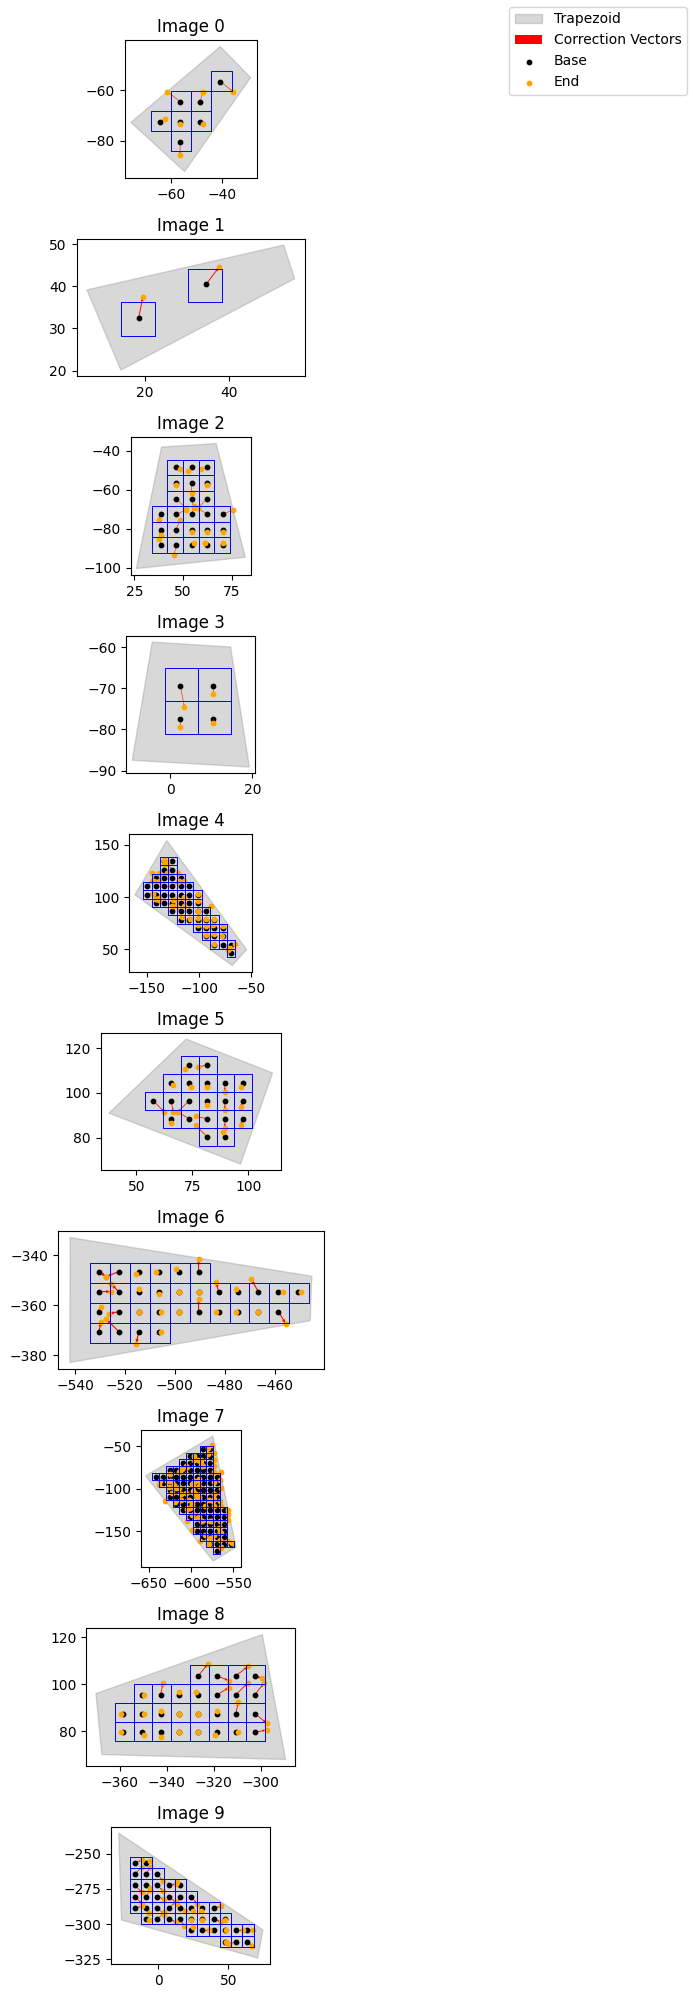

In [20]:
%matplotlib inline
mdb_plotter.plot_microps_w_corVecs()

## 3. Softmax Function for SSD-Based Confidence

Given scores $s_1, s_2, \ldots, s_n$, the softmax function converts them into probabilities:

$$
p_i = \frac{\exp(s_i)}{\sum_j \exp(s_j)}
$$

Softmax: Larger scores receive exponentially more weight.

#### Applying Softmax to SSD Values

**lower SSD is better**, we convert SSD into softmax scores by negating them. We also subtract the minimum SSD value for numerical stability:

$$
p(\Delta x, \Delta y)
=
\frac{
    \exp\!\big(
        -\beta \big[
            \mathrm{SSD}(\Delta x, \Delta y)
            - \mathrm{SSD}_{\min}
        \big]
    \big)
}{
    \displaystyle
    \sum_{u=-5}^{5}
    \sum_{v=-5}^{5}
    \exp\!\big(
        -\beta \big[
            \mathrm{SSD}(u, v)
            - \mathrm{SSD}_{\min}
        \big]
    \big)
}
$$

Where:

- **SSD(Δx, Δy)**  
  The SSD value at shift $(\Delta x, \Delta y)$ in the 11×11 grid.

- **SSD_min**  
  The minimum SSD value (stability)

- **β (beta)**  
  A positive scalar controlling sharpness of the distribution.
  - Using 1/std of ssd values
  - Larger β: more peaked probabilities (higher confidence)  
  - Smaller β: flatter probabilities (lower confidence)

## Mean and std

This probabilistic representation allows computation of:

Mean shift vector:

$$
\mu
=
\begin{bmatrix}
\mu_x \\
\mu_y
\end{bmatrix}
=
\sum_{u=-5}^{5}
\sum_{v=-5}^{5}
p(u,v)
\begin{bmatrix}
u \\
v
\end{bmatrix}
$$

Covariance matrix:

$$
\Sigma
=
\sum_{u=-5}^{5}
\sum_{v=-5}^{5}
p(u,v)
\left(
\begin{bmatrix}
u \\
v
\end{bmatrix}
-
\mu
\right)
\left(
\begin{bmatrix}
u \\
v
\end{bmatrix}
-
\mu
\right)^{T}
$$

## Full patch softmax

In [21]:
# Through each patch and micro-patch, generate probability distb
mpa.prob_distb_FP = [{} for _ in range(gnav.im_num)]
mpa.ssds_curr_SM = [{} for _ in range(gnav.im_num)]
maxp = 0
# for imnum in range(gnav.im_num):
#     # Grab ssds - FOR FULL PATCH (WE SHOULD SAVE AND REPLUG THIS DATA *****)
#     ssds = gnav.ssd_nxn(n_ssd, imnum)
#     mpa.ssds_curr_SM[imnum] = ssds

In [22]:
# # Save SSDs for runtime help 
# # Save data as pickle 
# fn = 'ssd_curr_SM_10IMG.pkl'
# with open(fn, 'wb') as f:
#     pickle.dump(mpa.ssds_curr_SM, f)

# Import pickle data structure so we do not have to run again
# Load
with open('ssd_curr_SM_10IMG.pkl', 'rb') as f:
    ssds_curr_SM_pkl = pickle.load(f)

# # Sanity check
# for imnum in range(len(gnav.images_dict)):
#     diff = mpa.ssds_curr_SM[imnum] - ssds_curr_SM_pkl[imnum]
#     print("DIFF", diff)

In [23]:
# Set to prev calculated
mpa.ssds_curr_SM = ssds_curr_SM_pkl
gnav.ssds_curr_SM = ssds_curr_SM_pkl

In [24]:
# Softmax distribution for each FULL patch - generates mpa.prob_distb_FP
mpa.FP_softmax()
# print(mpa.prob_distb_FP[0]['probs'])

## 4. Determining $P_i$


We define $P_i$ as the cumulative probability of all 'hypotheses' whose probability is greater than the ground-truth hypothesis at the $(0,0)$ shift, or $P_{\mathrm{GT}}$.



$$
P_{\mathrm{GT}} \;=\; p(0,0)
$$

$$
P_i \;=\; \sum_{(\Delta x,\Delta y)\in \mathcal{S}_i} p(\Delta x,\Delta y)
$$

$$
\mathcal{S}_i \;=\; \left\{(\Delta x,\Delta y)\;:\; p(\Delta x,\Delta y) > P_{\mathrm{GT}} \right\}
$$


STEPS
- [x] Visualize surface plot of probabilities with $(0,0)$ marked
- [x] Determine probabilities greater than $P_{GT}$
- [x] Sum these probabilities - THE $X$-axis, $P_i$
- [x] calculate CDF of probs (amount of probabilities over $P_{GT}$) - THE $Y$-axis
- [x] Plot results

In [25]:
# Surface plot visualization 
%matplotlib qt
# %matplotlib inline
imnum = 1
probs = mpa.prob_distb_FP[imnum]['probs']
mdb_plotter.ssd_surface_plots(probs, imnum, n_ssd, method='probs')

Highest probability shift for image 1: -1 -1


libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 80
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 80
pci id for fd 80: 8086:a7a0, driver iris
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using DRI3 for screen 0


In [26]:
# Set ground truth
p = mpa.im_num
gt = [0,0]
idrow, idcol = gt[0] + n_ssd, gt[1] + n_ssd
Pi_p = np.zeros((p))
cdf = np.zeros((p))
l_total = (n_ssd*2 + 1)**2
print("ID of row and col for P_GT:", idrow, idcol)
# Determine P_i for each image 
for imnum in range(mpa.im_num):
    probs = mpa.prob_distb_FP[imnum]['probs']
    pgt = probs[idrow, idcol]
    # print("Probabilities\n", probs)
    print("\nProbability of ground truth:", pgt)
    mask = probs > pgt
    # print("\nMask of probabilities:\n",mask)
    probs_p_ind = np.argwhere(probs > pgt)
    # print("\nProbs over PGT (indices):\n", probs_p_ind)
    probs_p = probs[mask]
    l_probs = len(probs_p)
    print(f"\nProbs over PGT, length {l_probs}:\n", probs_p)
    P_i = np.sum(probs_p)
    print("\nP_i:", P_i)
    print("\nCDF:", l_probs/l_total)
    Pi_p[imnum] = P_i
    cdf[imnum] = l_probs / l_total

print("\nFINAL P_i's: \n", Pi_p)

ID of row and col for P_GT: 5 5

Probability of ground truth: 0.028593449322676646

Probs over PGT, length 7:
 [0.03132776 0.03202764 0.03944457 0.03987168 0.03576159 0.03162496
 0.02932689]

P_i: 0.23938508185020074

CDF: 0.05785123966942149

Probability of ground truth: 0.027664812908396466

Probs over PGT, length 5:
 [0.02900267 0.0351784  0.03233426 0.02936411 0.03370879]

P_i: 0.15958823004246883

CDF: 0.04132231404958678

Probability of ground truth: 0.0584023664743979

Probs over PGT, length 1:
 [0.06058101]

P_i: 0.06058100509573919

CDF: 0.008264462809917356

Probability of ground truth: 0.030706596688501227

Probs over PGT, length 5:
 [0.03071256 0.03274872 0.03441794 0.03476045 0.03132514]

P_i: 0.1639648010741115

CDF: 0.04132231404958678

Probability of ground truth: 0.04515233856414332

Probs over PGT, length 2:
 [0.05634053 0.05009532]

P_i: 0.10643585468983432

CDF: 0.01652892561983471

Probability of ground truth: 0.031118655805607517

Probs over PGT, length 6:
 [0.035

### Plot description

- The x-axis shows our calculated $P_i$ for each patch (image).
    - This is the sum of the probabilities that are greater than the probability of the ground truth $P_{GT}$ at $(0,0)$
- The y-axis shows probability that this actually occured (the number of measurements over the total number of measurements)
- A $y=x$ line is shown as a reference
    - Thus, curves above the line show that the probability occured more frequently than predicted (overconfident)
    - Curves below the line show that the probability occured less frquently than predicted - (underconfident)

Overall: need more data

In [27]:
# PLOT 
Pi_ind_p = np.argsort(Pi_p)
# print(Pi_ind_p)
Pi_p_sorted = Pi_p[Pi_ind_p]
cdf_sorted = cdf[Pi_ind_p]

N = len(Pi_p)
cdf_new = np.linspace(0,len(Pi_p_sorted)-1, len(Pi_p_sorted))/len(Pi_p_sorted)
cdf_new = np.arange(1,N+1)/N
print(cdf_new)




# ---- Plot ----
plt.figure(figsize=(6, 5))
# OLD
# plt.plot(Pi_p_sorted, cdf_sorted, linewidth=2, label="Empirical CDF of $P_i$")
# plt.scatter(Pi_p_sorted, cdf_sorted, c='blue')
# NEW
plt.plot(Pi_p_sorted, cdf_new, linewidth=2, label="Empirical CDF of $P_i$")
plt.scatter(Pi_p_sorted, cdf_new, c='blue')
plt.plot([0, 1], [0, 1], "--", linewidth=2, label="Reference: $y=x$")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("$P_i$: PDF")
plt.ylabel("CDF")
plt.title("Empirical CDF of $P_i$")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [28]:
print(mpa.prob_distb_FP[1])

{'mu': array([-0.82859155, -0.99678817]), 'cov': array([[ 5.66238954, -1.45679945],
       [-1.45679945,  7.48460954]]), 'probs': array([[0.00867548, 0.00811945, 0.00752369, 0.00721773, 0.00677006,
        0.00640456, 0.00618115, 0.00602264, 0.00566353, 0.00528921,
        0.00536308],
       [0.00790935, 0.00734453, 0.00710709, 0.00722918, 0.00704608,
        0.00654509, 0.006563  , 0.00634023, 0.00636217, 0.00652126,
        0.00635543],
       [0.00802073, 0.00745367, 0.00774933, 0.00856379, 0.00898563,
        0.00859146, 0.00836635, 0.00796083, 0.00785884, 0.00705064,
        0.00603115],
       [0.01053361, 0.01054034, 0.011896  , 0.01484627, 0.01744569,
        0.01651863, 0.01413262, 0.01209313, 0.00936351, 0.00715724,
        0.00549221],
       [0.01552357, 0.01662819, 0.02027786, 0.02900267, 0.0351784 ,
        0.03233426, 0.02199366, 0.01455991, 0.00992836, 0.00693501,
        0.00514269],
       [0.01641888, 0.01792323, 0.0226217 , 0.02936411, 0.03370879,
        0.0276648

# Micropatch calibration analysis

Representing the error probability for the state estimation of an image patch, through a series of micropatch estimations

Each patch $X_i$ is made up of $n$ micropatches 

The probability of the ground truth $P_{GT}$ is the probability of the a patch measurment at $(0,0)$

The probability measure encompassing ground truth for each patch is $P_{MG}$

$$
P_{MG}(x) \;=\; \frac{1}{n} \sum_{n=1}^{n} norm.pdf(x_i : \mu_i, cov_i)
$$

4 Step process:

1.  Micropatch 2D errors - blur with gaussianc
2.  Continuous pdf from mixture of gaussians
3.  discrete distribution - sample pdf on SSD grid (and normalize samples to sum to 1)
4.  Watershed to ground truth @ 0 (as for softmax process)

ASSUMPTIONS:
- blurring function - setting at 3 pixel $\sigma$
- grid resolution in step 3 - will run a test for reliability

STEPS:
- [x] Obtain error vectors from mps
- [x] Create continuous pdf from mixture of blurred gaussians
- [ ] VERIFICATION
- [x] Sample discrete distribution
- [x] normalize
- [x] Watershed to ground truth
- [x] Sort
- [x] Plot!

In [29]:
# Probability distribution generated FOR the full patch BY the micropatch process 
mpa.prob_distb_MP = [{} for i in range(mpa.im_num)]
print(mpa.prob_distb_MP)

[{}, {}, {}, {}, {}, {}, {}, {}, {}, {}]


In [30]:
def cont_pdf_gblur(x, distb_vecs, sigma_pix):
    assert distb_vecs.ndim == 2 and distb_vecs.shape[1] == 2
    cov = np.eye(2) * (sigma_pix**2)
    vals = [multivariate_normal.pdf(x, mean=mu, cov = cov) for mu in distb_vecs]
    return np.mean(vals)

In [31]:
# # Sum across all images
# n_ssd = 5
# sigma_pix = 3
# GT_pos = np.array([0,0])
# Pi_p_microp = np.zeros((mpa.im_num))

# # print(GT_pos.shape)
# for imnum in range(mpa.im_num):
#     distb_vecs_im = mpa.distb_vecs[imnum]
#     # LOOP OVER SSD 
#     ssds_prob = np.zeros((2*n_ssd + 1, 2*n_ssd + 1))
#     count = 0
#     for xshift in range(-n_ssd, n_ssd+1):
#         for yshift in range(-n_ssd, n_ssd+1):
#             count +=1
#             shift = np.array([xshift, yshift])
#             # print("SSD shift:", xshift, yshift)
#             xind = xshift + n_ssd
#             yind = yshift + n_ssd
#             # print("X and Y ind:", xind, yind)
#             # p_x = cont_pdf_gblur(shift, distb_vecs_im, sigma_pix) # Need MULTI-VAR***
#             p_x = cont_pdf_gblur(shift, distb_vecs_im, sigma_pix)
#             # print("P_x:", p_x)
#             # print(f"COMPARISON:\nSingle-var(?): {p_x} \nMulti-var: {p_x2}")
#             ssds_prob[xind,yind] = p_x

#     # Normalize and place probabilities in dict and 
#     # print(f"Discrete probabilites for image {imnum}: \n{ssds_prob}")
#     sum_probs = np.sum(ssds_prob)
#     # print("SUM of probabilities:", sum_probs)
#     norm_probs = ssds_prob / sum_probs
#     mpa.prob_distb_MP[imnum]['probs'] = norm_probs
#     # print("Normalized probabilities:", norm_probs)

#     # Watershed for gt
#     pgt = norm_probs[n_ssd, n_ssd] # Ground truth probability
#     mask = norm_probs >= pgt
#     probs_over_gt = norm_probs[mask]
#     l_probs = len(probs_over_gt)
#     # print(f"\nProbs over PGT, length {l_probs}:\n", np.round(probs_over_gt,4))
#     P_i = np.sum(probs_over_gt)
#     print('\nP_i: %.3f' % P_i)
#     Pi_p_microp[imnum] = P_i

# print(f"\nFINAL P_i's: {Pi_p_microp}")
# Pi_p_microp_OLD = Pi_p_microp # For comparison 

In [32]:
# Define variables
n_ssd = 5 # SSD full shift 
sigma_pix = 3 # Gaussian blur param
GT_pos = np.array([0,0]) # Position of ground truth
Pi_p_microp = np.zeros((mpa.im_num)) # eCDF probabilities
step = 1 # Grid size 
steps_TEST = [.05, 1, 25, .5, 1] 
Pi_p_microp_GRID_TEST = []
shifts = np.arange(-n_ssd, n_ssd+step, step) 
print(f'Shifts: {shifts}')
N = len(shifts)


# print(GT_pos.shape)
for imnum in range(mpa.im_num):
    distb_vecs_im = mpa.distb_vecs[imnum]
    # LOOP OVER SSD 
    # ssds_prob = np.zeros((2*n_ssd + 1, 2*n_ssd + 1))
    ssds_prob = np.zeros((N,N))
    count = 0
    for i, xshift in enumerate(shifts):
        for j, yshift in enumerate(shifts):
            count +=1
            shift = np.array([xshift, yshift])
            # print("SSD shift:", xshift, yshift)
            p_x = cont_pdf_gblur(shift, distb_vecs_im, sigma_pix)
            # print("P_x:", p_x)
            # ssds_prob[xind,yind] = p_x
            ssds_prob[i,j] = p_x

    # Normalize and place probabilities in dict and 
    # print(f"Discrete probabilites for image {imnum}: \n{ssds_prob}")
    sum_probs = np.sum(ssds_prob)
    # print("SUM of probabilities:", sum_probs)
    norm_probs = ssds_prob / sum_probs
    mpa.prob_distb_MP[imnum]['probs'] = norm_probs
    # print("Normalized probabilities:", norm_probs)

    # Watershed for gt
    ix = np.argmin(np.abs(shifts - GT_pos[0]))
    iy = np.argmin(np.abs(shifts - GT_pos[1]))
    # pgt = norm_probs[n_ssd, n_ssd] # Ground truth probability
    pgt = norm_probs[ix,iy]
    # print(f'Ground truth probability indices: {ix,iy}')
    # print(f'Ground truth probability: {pgt}')
    mask = norm_probs >= pgt
    probs_over_gt = norm_probs[mask]
    l_probs = len(probs_over_gt)
    # print(f"\nProbs over PGT, length {l_probs}:\n", np.round(probs_over_gt,4))
    P_i = np.sum(probs_over_gt)
    print('\nP_i: %.3f' % P_i)
    Pi_p_microp[imnum] = P_i

print(f"\nFINAL P_i's: {Pi_p_microp}")
Pi_p_microp_INITIAL = Pi_p_microp


Shifts: [-5 -4 -3 -2 -1  0  1  2  3  4  5]

P_i: 0.097

P_i: 0.847

P_i: 0.058

P_i: 0.278

P_i: 0.367

P_i: 0.337

P_i: 0.016

P_i: 0.425

P_i: 0.032

P_i: 0.483

FINAL P_i's: [0.09744856 0.84661112 0.05757947 0.27755763 0.36658094 0.33659318
 0.01604714 0.42493301 0.03229209 0.4825118 ]


In [33]:
# Surface plot visualization 
%matplotlib qt
# %matplotlib inline
imnum = 0
probs = mpa.prob_distb_MP[imnum]['probs']
mdb_plotter.ssd_surface_plots(probs, imnum, n_ssd, method='probs')

Highest probability shift for image 0: 1 -1


# Grid dependency test

In [34]:
# Import pickle data structure so we do not have to run again
# Load
with open('grid_dep_probs_ecdf.pkl', 'rb') as f:
    Pi_p_microp_GRID_TEST_PKL = pickle.load(f)

In [35]:
# # Define variables
# n_ssd = 5 # SSD full shift 
# sigma_pix = 3 # Gaussian blur param
# GT_pos = np.array([0,0]) # Position of ground truth
# # Pi_p_microp = np.zeros((mpa.im_num)) # eCDF probabilities
# # step = 1 # Grid size 
# # shifts = np.arange(-n_ssd, n_ssd+step, step) 
# # print(f'Shifts: {shifts}')
# # N = len(shifts)

# steps_TEST = [.05, .1, .25, .5, 1] 
# Pi_p_microp_GRID_TEST = []

# # print(GT_pos.shape)
# for step in steps_TEST:
#     print(f'Current step = {step}')
#     # Reset variables
#     shifts = np.arange(-n_ssd, n_ssd+step, step) 
#     # print(f'Shifts: {shifts}')
#     N = len(shifts)
#     Pi_p_microp = np.zeros((mpa.im_num))
    
#     for imnum in range(mpa.im_num):
#         distb_vecs_im = mpa.distb_vecs[imnum]
#         # LOOP OVER SSD 
#         # ssds_prob = np.zeros((2*n_ssd + 1, 2*n_ssd + 1))
#         ssds_prob = np.zeros((N,N))
#         count = 0
#         for i, xshift in enumerate(shifts):
#             for j, yshift in enumerate(shifts):
#                 count +=1
#                 shift = np.array([xshift, yshift])
#                 # print("SSD shift:", xshift, yshift)
#                 p_x = cont_pdf_gblur(shift, distb_vecs_im, sigma_pix)
#                 # print("P_x:", p_x)
#                 # ssds_prob[xind,yind] = p_x
#                 ssds_prob[i,j] = p_x
    
#         # Normalize and place probabilities in dict and 
#         # print(f"Discrete probabilites for image {imnum}: \n{ssds_prob}")
#         sum_probs = np.sum(ssds_prob)
#         # print("SUM of probabilities:", sum_probs)
#         norm_probs = ssds_prob / sum_probs
#         mpa.prob_distb_MP[imnum]['probs'] = norm_probs
#         # print("Normalized probabilities:", norm_probs)
    
#         # Watershed for gt
#         ix = np.argmin(np.abs(shifts - GT_pos[0]))
#         iy = np.argmin(np.abs(shifts - GT_pos[1]))
#         # pgt = norm_probs[n_ssd, n_ssd] # Ground truth probability
#         pgt = norm_probs[ix,iy]
#         # print(f'Ground truth probability indices: {ix,iy}')
#         # print(f'Ground truth probability: {pgt}')
#         mask = norm_probs >= pgt
#         probs_over_gt = norm_probs[mask]
#         l_probs = len(probs_over_gt)
#         # print(f"\nProbs over PGT, length {l_probs}:\n", np.round(probs_over_gt,4))
#         P_i = np.sum(probs_over_gt)
#         print('\nP_i: %.3f' % P_i)
#         Pi_p_microp[imnum] = P_i
    
#     print(f"\nFINAL P_i's: {Pi_p_microp}")
#     Pi_p_microp_GRID_TEST.append(Pi_p_microp)

Pi_p_microp_GRID_TEST = Pi_p_microp_GRID_TEST_PKL
print(f'GRID DEPENDENCY test results: {Pi_p_microp_GRID_TEST}')


GRID DEPENDENCY test results: [array([0.08603667, 0.82899568, 0.0503853 , 0.30902633, 0.39341531,
       0.36757127, 0.01200508, 0.42997616, 0.02412154, 0.50306524]), array([0.08519731, 0.82951576, 0.0503628 , 0.30776682, 0.39220243,
       0.36614754, 0.01211793, 0.42940683, 0.02412671, 0.50259918]), array([0.08609935, 0.82920266, 0.05102979, 0.30029886, 0.38932531,
       0.3597367 , 0.01296671, 0.42343037, 0.02401038, 0.4973177 ]), array([0.08896785, 0.83112288, 0.05336633, 0.29871122, 0.38082824,
       0.34991547, 0.0126497 , 0.41359065, 0.02551943, 0.49177634]), array([0.09744856, 0.84661112, 0.05757947, 0.27755763, 0.36658094,
       0.33659318, 0.01604714, 0.42493301, 0.03229209, 0.4825118 ])]


# Variance dependency 

In [36]:
# Define variables
n_ssd = 5 # SSD full shift 
sigma_pix = 3 # Gaussian blur param
GT_pos = np.array([0,0]) # Position of ground truth
# Pi_p_microp = np.zeros((mpa.im_num)) # eCDF probabilities
step = 1 # Grid size 
shifts = np.arange(-n_ssd, n_ssd+step, step) 
print(f'Shifts: {shifts}')
N = len(shifts)

sigma_TEST = [0.1,0.5,1,2,3,4] 
Pi_p_microp_sigma_TEST = []

# print(GT_pos.shape)
for sigma_pix in sigma_TEST:
    print(f'Current sigma = {sigma_pix}')
    # Reset variables
    Pi_p_microp = np.zeros((mpa.im_num))
    
    for imnum in range(mpa.im_num):
        distb_vecs_im = mpa.distb_vecs[imnum]
        # LOOP OVER SSD 
        # ssds_prob = np.zeros((2*n_ssd + 1, 2*n_ssd + 1))
        ssds_prob = np.zeros((N,N))
        count = 0
        for i, xshift in enumerate(shifts):
            for j, yshift in enumerate(shifts):
                count +=1
                shift = np.array([xshift, yshift])
                # print("SSD shift:", xshift, yshift)
                p_x = cont_pdf_gblur(shift, distb_vecs_im, sigma_pix)
                # print("P_x:", p_x)
                # ssds_prob[xind,yind] = p_x
                ssds_prob[i,j] = p_x
    
        # Normalize and place probabilities in dict and 
        # print(f"Discrete probabilites for image {imnum}: \n{ssds_prob}")
        sum_probs = np.sum(ssds_prob)
        # print("SUM of probabilities:", sum_probs)
        norm_probs = ssds_prob / sum_probs
        mpa.prob_distb_MP[imnum]['probs'] = norm_probs
        # print("Normalized probabilities:", norm_probs)
    
        # Watershed for gt
        ix = np.argmin(np.abs(shifts - GT_pos[0]))
        iy = np.argmin(np.abs(shifts - GT_pos[1]))
        # pgt = norm_probs[n_ssd, n_ssd] # Ground truth probability
        pgt = norm_probs[ix,iy]
        # print(f'Ground truth probability indices: {ix,iy}')
        # print(f'Ground truth probability: {pgt}')
        mask = norm_probs >= pgt
        probs_over_gt = norm_probs[mask]
        l_probs = len(probs_over_gt)
        # print(f"\nProbs over PGT, length {l_probs}:\n", np.round(probs_over_gt,4))
        P_i = np.sum(probs_over_gt)
        print('\nP_i: %.3f' % P_i)
        Pi_p_microp[imnum] = P_i
    
    print(f"\nFINAL P_i's: {Pi_p_microp}")
    Pi_p_microp_sigma_TEST.append(Pi_p_microp)

print(f'SIGMA DEPENDENCY test results: {Pi_p_microp_sigma_TEST}')


Shifts: [-5 -4 -3 -2 -1  0  1  2  3  4  5]
Current sigma = 0.1

P_i: 1.000

P_i: 1.000

P_i: 1.000

P_i: 1.000

P_i: 1.000

P_i: 1.000

P_i: 0.161

P_i: 1.000

P_i: 0.148

P_i: 1.000

FINAL P_i's: [1.         1.         1.         1.         1.         1.
 0.16129032 1.         0.14814815 1.        ]
Current sigma = 0.5

P_i: 0.718

P_i: 1.000

P_i: 0.705

P_i: 0.911

P_i: 0.515

P_i: 0.993

P_i: 0.126

P_i: 0.637

P_i: 0.123

P_i: 0.817

FINAL P_i's: [0.71790126 1.         0.70500963 0.91136087 0.5153892  0.99254042
 0.12637358 0.6374268  0.12303582 0.81738278]
Current sigma = 1

P_i: 0.210

P_i: 1.000

P_i: 0.079

P_i: 0.644

P_i: 0.379

P_i: 0.728

P_i: 0.063

P_i: 0.606

P_i: 0.068

P_i: 0.490

FINAL P_i's: [0.21042899 0.99999765 0.07852554 0.64366451 0.37858306 0.72820062
 0.06309648 0.60574671 0.06806273 0.49036403]
Current sigma = 2

P_i: 0.095

P_i: 0.978

P_i: 0.059

P_i: 0.360

P_i: 0.298

P_i: 0.450

P_i: 0.025

P_i: 0.827

P_i: 0.027

P_i: 0.551

FINAL P_i's: [0.0952941  0.

In [37]:
# # COMPARISON
# for i in range(len(Pi_p_microp)):
#     diff = Pi_p_microp[i] - Pi_p_microp_OLD[i]
#     print(f'DIFFERENCE: {diff}')

In [38]:
# PLOT 
N1 = len(Pi_p)
Pi_p_sorted = np.sort(Pi_p)
cdf1 = np.arange(1,N1+1)/N1
# cdf1 = np.arange(0,N1)/N1

# SECOND PLOT 
N2 = len(Pi_p_microp_INITIAL)
Pi_p_microp_sorted = np.sort(Pi_p_microp_INITIAL)
cdf2 = np.arange(1,N2+1)/N2
print(Pi_p_microp_sorted)
print(f"Micropatch PDF probabilities: \n{np.round(Pi_p_microp_sorted,3)}")
# cdf2 = np.arange(0,N2)/N2

# ---- Plot ----
plt.figure(figsize=(6, 5))
# NEW
plt.plot(Pi_p_sorted, cdf1, linewidth=2, label="eCDF of $P_i$ (Softmax)")
plt.scatter(Pi_p_sorted, cdf1, c='blue')
plt.plot(Pi_p_microp_sorted, cdf2, linewidth=2, label="eCDF of $P_i$ (micropatches)")
plt.scatter(Pi_p_microp_sorted, cdf2, c='orange')
plt.plot([0, 1], [0, 1], "--", linewidth=2, label="Reference: $y=x$")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("$P_i$: PDF")
plt.ylabel("CDF")
plt.title("Empirical CDF of $P_i$")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

[0.01604714 0.03229209 0.05757947 0.09744856 0.27755763 0.33659318
 0.36658094 0.42493301 0.4825118  0.84661112]
Micropatch PDF probabilities: 
[0.016 0.032 0.058 0.097 0.278 0.337 0.367 0.425 0.483 0.847]


In [39]:
# ========= GRID DEPENDENCY =============
# ---- Baseline (softmax) eCDF ----
Pi_p_sorted = np.sort(Pi_p)
N1 = len(Pi_p_sorted)
cdf1 = np.arange(1, N1 + 1) / N1

plt.figure(figsize=(6, 5))

plt.plot(Pi_p_sorted, cdf1, linewidth=2, label="eCDF of $P_i$ (Softmax)")
plt.scatter(Pi_p_sorted, cdf1, s=15)  # no fixed color

# ---- Micropatch grid-dependency eCDFs ----
for step, Pi_step in zip(steps_TEST, Pi_p_microp_GRID_TEST):
    Pi_step_sorted = np.sort(Pi_step)
    N = len(Pi_step_sorted)
    cdf = np.arange(1, N + 1) / N

    plt.plot(Pi_step_sorted, cdf, linewidth=2, label=f"micropatches (step={step})")
    # optional scatter if you want it:
    # plt.scatter(Pi_step_sorted, cdf, s=10)

# Reference line
plt.plot([0, 1], [0, 1], "--", linewidth=2, label="Reference: $y=x$")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("$P_i$")
plt.ylabel("CDF")
plt.title("Grid Dependency: Empirical CDF of $P_i$")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [40]:
# ========= SIGMA DEPENDENCY =============
# ---- Baseline (softmax) eCDF ----
Pi_p_sorted = np.sort(Pi_p)
N1 = len(Pi_p_sorted)
cdf1 = np.arange(1, N1 + 1) / N1

plt.figure(figsize=(6, 5))

plt.plot(Pi_p_sorted, cdf1, linewidth=2, label="eCDF of $P_i$ (Softmax)")
plt.scatter(Pi_p_sorted, cdf1, s=15)  # no fixed color

# ---- Micropatch grid-dependency eCDFs ----
for sigma, Pi_sigma in zip(sigma_TEST, Pi_p_microp_sigma_TEST):
    Pi_sigma_sorted = np.sort(Pi_sigma)
    N = len(Pi_sigma_sorted)
    cdf = np.arange(1, N + 1) / N

    plt.plot(Pi_sigma_sorted, cdf, linewidth=2, label=f"micropatches ($\sigma$={sigma})")
    # optional scatter if you want it:
    # plt.scatter(Pi_step_sorted, cdf, s=10)

# Reference line
plt.plot([0, 1], [0, 1], "--", linewidth=2, label="Reference: $y=x$")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("$P_i$")
plt.ylabel("CDF")
plt.title("$\sigma$ Dependency: Empirical CDF of $P_i$")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
